# HW 4: Variational Autoencoders

In this homework you will build a deep generative model of binary images (MNIST) using variational autoencoders and generative adversarial networks.
The original VAE paper can be found [here](https://arxiv.org/abs/1312.6114) and GANs [here](https://arxiv.org/abs/1406.2661), and there are many excellent tutorials
online, e.g. [here](https://arxiv.org/abs/1606.05908) and [here](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

**For this homework there will not be a Kaggle submission**

## Goals


1. Build a discrete deep generative model of binary digits (MNIST) using variational autoencoders
2. Examine the learned latent space with visualizations 
3. Build a conditinous deep geneartive model using generative adversarial networks.
4. Additionally extend the above in any way, for example by :
    - using better encoder/decoders (e.g. CNN as the encoder, PixelCNN as the decoder. Description of PixelCNN 
    can be found [here](https://arxiv.org/abs/1601.06759))
    - using different variational families, e.g. with [normalizing flows](https://arxiv.org/abs/1505.05770), 
    [inverse autoregressive flows](https://arxiv.org/pdf/1606.04934.pdf), 
    [hierarchical models](https://arxiv.org/pdf/1602.02282.pdf)
    - comparing with stochastic variational inference (i.e. where your variational parameters are randomly initialized and
    then updated with gradient ascent on the ELBO
    - or your own extension.

For your encoder/decoder, we suggest starting off with simple models (e.g. 2-layer MLP with ReLUs).

Consult the papers provided for hyperparameters, and the course notes for formal definitions.


## Setup

This notebook provides a working definition of the setup of the problem itself. Feel free to construct your models inline, or use an external setup (preferred) to build your system.

First, as always, let's download the data.

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
train_dataset = datasets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

In [ ]:
print(len(train_dataset))
print(len(test_dataset))
train_dataset[0][0]

By default MNIST gives grayscale values between [0,1]. Since we are modeling binary images, we have to turn these
into binary values, i.e. $\{0,1\}^{784}$). A standard way to do this is to interpret the grayscale values as 
probabilities and sample Bernoulli random vectors based on these probabilities. (Note you should not do this for GANs)


In [ ]:
torch.manual_seed(3435)
train_img = torch.stack([torch.bernoulli(d[0]) for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
test_img = torch.stack([torch.bernoulli(d[0]) for d in test_dataset])
test_label = torch.LongTensor([d[1] for d in test_dataset])
print(train_img[0])
print(train_img.size(), train_label.size(), test_img.size(), test_label.size())
                        

MNIST does not have an official train dataset. So we will use the last 10000 training points as your validation set.

In [ ]:
val_img = train_img[-10000:].clone()
val_label = train_label[-10000:].clone()
train_img = train_img[:10000]
train_label = train_label[:10000]

Now we use the dataloader to split into batches.

In [ ]:
train = torch.utils.data.TensorDataset(train_img, train_label)
val = torch.utils.data.TensorDataset(val_img, val_label)
test = torch.utils.data.TensorDataset(test_img, test_label)
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
for datum in train_loader:
    img, label = datum
    print(img.size(), label.size())
    break

Great now we are ready to begin modeling. Performance-wise, you want tune your hyperparameters based on the **evidence lower bound (ELBO)**. Recall that the ELBO is given by:

$$ELBO = \mathbb{E}_{q(\mathbf{z} ; \lambda)} [\log p(\mathbf{x} \,|\,\mathbf{z} ; \theta)] - \mathbb{KL}[q(\mathbf{z};\lambda) \, \Vert \, p(\mathbf{z})]$$

The variational parameters are given by running the encoder over the input, i..e. $\lambda = encoder(\mathbf{x};\phi)$. The generative model (i.e. decoder) is parameterized by $\theta$. Since we are working with binarized digits, $\log p(x \, | \, \mathbf{z} ; \theta)$ is given by:

$$ \log p(x \, | \, \mathbf{z} ; \theta) = \sum_{i=1}^{784} \log \sigma(\mathbf{h})_{i} $$

where $\mathbf{h}$ is the final layer of the generative model (i.e. 28*28 = 784 dimensionval vector), and $\sigma(\cdot)$ is the sigmoid function. 

For the baseline model in this assignment you will be using a spherical normal prior, i.e. $p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$. The variational family will also be normal, i.e. $q(\mathbf{z} ; \lambda) = \mathcal{N}(\boldsymbol{\mu}, \log \boldsymbol \sigma^2)$ (here we will work with normal families with diagonal covariance). The KL-divergence between the variational posterior $q(\mathbf{z})$ and the prior $p(\mathbf{z})$ has a closed-form analytic solution, which is available in the original VAE paper referenced above. (If you are using the torch distributions package they will automatically calculate it for you, however you will need to use pytorch 0.4).

# Question 1: Baseline VAE

## Set up 

In [73]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as img_utils

train_dataset = datasets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

In [2]:
torch.manual_seed(3435)
train_img = torch.stack([torch.bernoulli(d[0]) for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
test_img = torch.stack([torch.bernoulli(d[0]) for d in test_dataset])
test_label = torch.LongTensor([d[1] for d in test_dataset])
print(train_img.size(), train_label.size(), test_img.size(), test_label.size())

torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [3]:
val_img = train_img[-10000:].clone()
val_label = train_label[-10000:].clone()
train_img = train_img[:10000]
train_label = train_label[:10000]
train = torch.utils.data.TensorDataset(train_img, train_label)
val = torch.utils.data.TensorDataset(val_img, val_label)
test = torch.utils.data.TensorDataset(test_img, test_label)
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([100, 1, 28, 28]) torch.Size([100])


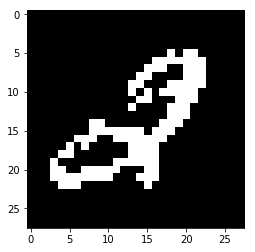

In [25]:
for datum in train_loader:
    img, label = datum
    print(img.size(), label.size())
    plt.imshow(img[3][0], cmap='gray')
    plt.show()

    break

## Model

In [225]:
import torch
import torch.nn as nn
import numpy as np 
from torch.autograd import Variable as V
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import matplotlib.patches as patches

In [248]:
LATENT_DIM = 5

# Compute the variational parameters for q
class Encoder(nn.Module):
    def __init__(self, output_size=28*28):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(output_size, 200)
        # mean 
        self.linear2 = nn.Linear(200, LATENT_DIM)
        # variance
        self.linear3 = nn.Linear(200, LATENT_DIM)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        return self.linear2(h), self.linear3(h) 
    
class Decoder(nn.Module):
    def __init__(self, output_size = 28*28):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(LATENT_DIM, 200)
        self.linear2 = nn.Linear(200, output_size)

    def forward(self, z):
        h = F.relu(self.linear1(z))
        return F.sigmoid(self.linear2(h))

In [249]:
class NormalVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(NormalVAE, self).__init__()

        # Parameters phi and computes variational parameters lambda
        self.encoder = encoder

        # Parameters theta, p(x | z)
        self.decoder = decoder
    
    def forward(self, x_src):
        # Example variational parameters lambda
        mu, logvar = self.encoder(x_src)
        q_normal = Normal(loc=mu, scale=logvar.mul(0.5).exp())
        
        # Reparameterized sample.
        z_sample = q_normal.rsample()
        #z_sample = mu
        return self.decoder(z_sample), mu, logvar 

In [250]:
bce_loss = nn.BCELoss(size_average=False)

# Problem setup.
encoder = Encoder()
decoder = Decoder()
vae = NormalVAE(encoder, decoder)

# SGD
learning_rate = 0.02
optim = torch.optim.SGD(vae.parameters(), lr = learning_rate)

NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    # Keep track of reconstruction loss and total kl
    total_loss = 0
    total_kl = 0
    total = 0
    for datum in train_loader:
        img, _ = datum
        img = V(img)
        img = img.view(-1, 784)
        # Standard setup. 
        vae.zero_grad()
        
        # Run VAE. 
        out, mu, logvar = vae(img)

        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # actual loss
        loss = bce_loss(out, img) + kl 
        loss = loss / BATCH_SIZE
        
        # record keeping.
        total_loss += mse_loss(out, img).data / BATCH_SIZE
        
        total_kl += kl.data / BATCH_SIZE
        total += 1
        loss.backward()
        optim.step()
    print(epoch, total_loss[0] / total , total_kl[0] / total)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0 
 151.3887
[torch.FloatTensor of size ()]
 
 9.1406
[torch.FloatTensor of size ()]

1 
 125.2926
[torch.FloatTensor of size ()]
 
 6.2397
[torch.FloatTensor of size ()]

2 
 112.9021
[torch.FloatTensor of size ()]
 
 8.7468
[torch.FloatTensor of size ()]

3 
 104.5925
[torch.FloatTensor of size ()]
 
 10.1922
[torch.FloatTensor of size ()]

4 
 98.1658
[torch.FloatTensor of size ()]
 
 10.7769
[torch.FloatTensor of size ()]

5 
 95.2384
[torch.FloatTensor of size ()]
 
 10.8729
[torch.FloatTensor of size ()]

6 
 93.3345
[torch.FloatTensor of size ()]
 
 11.0618
[torch.FloatTensor of size ()]

7 
 92.0833
[torch.FloatTensor of size ()]
 
 11.0396
[torch.FloatTensor of size ()]

8 
 90.6156
[torch.FloatTensor of size ()]
 
 11.0867
[torch.FloatTensor of size ()]

9 
 89.7778
[torch.FloatTensor of size ()]
 
 11.1300
[torch.FloatTensor of size ()]



## Q2: Visualization

In [260]:
%matplotlib inline
def show(img, n_row=5):
    img = img_utils.make_grid(img, n_row)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

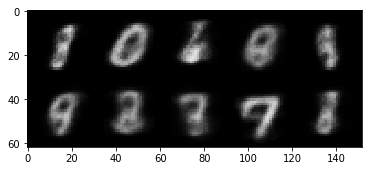

In [124]:
#2.1 Sample bunch of digits latent_dim = 5 
NUM_SAMPLES = 10 
#sample from p(z) standard normal 
m = Normal(torch.zeros(LATENT_DIM), torch.ones(LATENT_DIM))
sample = m.sample((NUM_SAMPLES, 1))
sample = V(sample.squeeze(1))

# sample from p(x|z) decoder
sample = decoder(sample)
show(sample.data.view(NUM_SAMPLES, 1, 28, 28))

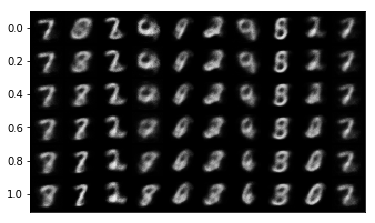

In [287]:
# 2.2 Linear Interpolation latent_dim = 5 
z_1 = m.sample((NUM_SAMPLES, 1))
z_2 = m.sample((NUM_SAMPLES, 1)) 
output_arr = torch.zeros((6, NUM_SAMPLES, 1, 28, 28))
i = 0 
for alpha in [0, 0.2, 0.4, 0.6, 0.8, 1.0]: 
    z_comb = alpha*z_1 + (1-alpha)*z_2
    sample = decoder(z_comb)
    output_arr[i] = sample.data.view(NUM_SAMPLES, 1, 28, 28)
    i += 1 
    
# locs, labels = plt.xticks()
# print(locs)
# print(labels)
plt.yticks(np.arange(0 + 15,6*30+15,30), ('0.0', '0.2', '0.4', '0.6', '0.8', '1.0'))
plt.xticks(())
show(output_arr.view(6*NUM_SAMPLES, 1, 28, 28) , 10)

In [181]:
# 2.3 latent_dim = 2 
label_x = [ [] for i in range(10)]
label_y = [ [] for i in range(10)]
for datum in list(test_loader): 
    img, label = datum
    img = V(img)
    img = img.view(-1, 784)
    dim = encoder(img)
    mu = dim[0]
    for i in range(BATCH_SIZE): 
        label_x[label[i].data.numpy()].append(mu[i].data.numpy()[0])
        label_y[label[i].data.numpy()].append(mu[i].data.numpy()[1])

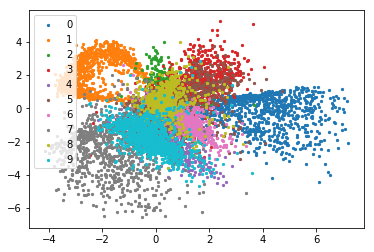

In [230]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(10): 
    ax1.scatter(label_x[i], label_y[i], s = 5, label=str(i))

plt.legend(loc='upper left');
plt.show()

In [243]:
# Mesh grid 
mesh_grid = np.asarray(np.meshgrid(np.linspace(-2, 2, 10), np.linspace(2, -2, 10)))

(2, 10, 10)


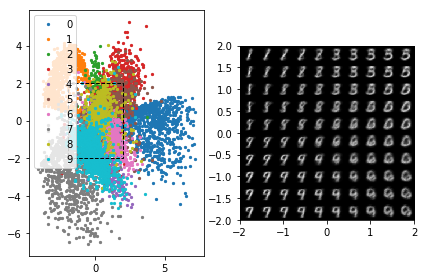

In [245]:
fig = plt.figure()
ax1 = plt.subplot(121)
for i in range(10): 
    ax1.scatter(label_x[i], label_y[i], s = 5, label=str(i))
ax1.legend(loc='upper left');

ax1.add_patch(patches.Rectangle(
        (-2, -2), 4, 4, fill=False,
        linestyle='dashed'))

GRID_SIZE = 10 
print(mesh_grid.shape)
z_1 = mesh_grid[0].reshape(GRID_SIZE*GRID_SIZE)
z_2 = mesh_grid[1].reshape(GRID_SIZE*GRID_SIZE)
output_arr = torch.zeros((100, 1, 28, 28))
i = 0 
for i in range(100): 
    input_z = torch.Tensor([z_1[i], z_2[i]])
    input_z = V(input_z)
    sample = decoder(input_z)
    output_arr[i] = sample.data.view(1, 1, 28, 28)
    i += 1 

ax2 = plt.subplot(122)
img = img_utils.make_grid(output_arr, 10)
npimg = img.numpy()
ax2.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', extent=[-2, 2, -2, 2])
fig.tight_layout()
plt.show()

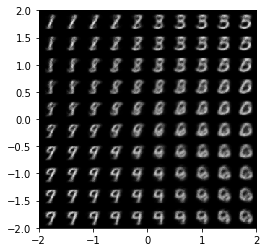

In [247]:
#larget image
GRID_SIZE = 10 

z_1 = mesh_grid[0].reshape(GRID_SIZE*GRID_SIZE)
z_2 = mesh_grid[1].reshape(GRID_SIZE*GRID_SIZE)
output_arr = torch.zeros((100, 1, 28, 28))
i = 0 
for i in range(100): 
    input_z = torch.Tensor([z_1[i], z_2[i]])
    input_z = V(input_z)
    sample = decoder(input_z)
    output_arr[i] = sample.data.view(1, 1, 28, 28)
    i += 1 
    
img = img_utils.make_grid(output_arr, 10)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', extent=[-2, 2, -2, 2])
plt.show()

For GANs you should use the same data in its continuous form. Here use the same prior, but use a multi-layer network to map to a continous 28x28 output space. Then use a multilayer discriminator to classify. 

For both models you may also consider trying a deconvolutional network (as in DCGAN) to produce output from the latent variable.

## Visualizations

In addition to quantitative metrics (i.e. ELBO), we are also going to ask you to do some qualitative analysis via visualizations. Please include the following in your report:

1. Generate a bunch of digits from your generative model (sample $\mathbf{z} \sim p(\mathbf{z})$, then $\mathbf{x} \sim p (\mathbf{x} \, | \, \mathbf{z} ; \theta$))
2. Sample two random latent vectors $\mathbf{z}_1, \mathbf{z}_2 \sim p(\mathbf{z})$, then sample from their interpolated values, i.e. $\mathbf{z} \sim p (\mathbf{x} \, | \, \alpha\mathbf{z}_1 + (1-\alpha)\mathbf{z}_2; \theta$) for $\alpha = \{0, 0.2, 0.4, 0.6, 0.8 ,1.0 \}$.
3. Train a VAE with 2 latent dimensions. Make a scatter plot of the variational means, $\mu_1, \mu_2$, where the color
corresponds to the digit.
4. With the same model as in (3), pick a 2d grid around the origin (0,0), e.g. with
`np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10)`. For each point in the grid $(z_1, z_2)$, generate
$\mathbf{x}$ and show the corresponding digit in the 2d plot. For an example see [here](http://fastforwardlabs.github.io/blog-images/miriam/tableau.1493x693.png) (the right image)
